In [1]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F
from torchvision.transforms import Compose, Resize, ToTensor
from torchsummary import summary

from  PIL import Image
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

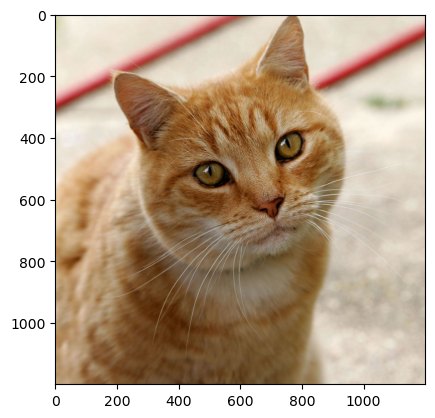

In [2]:
img = Image.open('./cat.jpg')
fig = plt.figure()
plt.imshow(img)

In [3]:
transform  = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0)
x.shape

torch.Size([1, 3, 224, 224])

In [4]:
patch_size = 16
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
patches

tensor([[[0.8510, 0.8196, 0.6902,  ..., 0.9451, 0.9216, 0.8588],
         [0.9647, 0.9412, 0.8941,  ..., 0.9373, 0.8902, 0.8275],
         [0.9647, 0.9412, 0.8902,  ..., 0.9176, 0.8824, 0.8157],
         ...,
         [0.9098, 0.8588, 0.7961,  ..., 0.8627, 0.8118, 0.7490],
         [0.8706, 0.8314, 0.7843,  ..., 0.8784, 0.8314, 0.7686],
         [0.8314, 0.7843, 0.7176,  ..., 0.8824, 0.8353, 0.7725]]])

In [5]:
x.shape, patches.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 196, 768]))

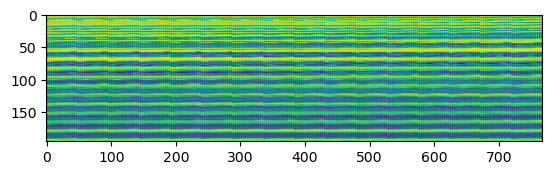

In [6]:
plt.imshow(patches.squeeze())

In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
        Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
        nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
        
    def forward(self, x):
        x = self.projection(x)
        return x

In [8]:
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

In [9]:
class PatchEmbedding_Conv(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
        nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
        Rearrange('b e (h) (w) -> b (h w) e')
        )
        
    def forward(self, x):
        x = self.projection(x)
        return x
    
PatchEmbedding_Conv()(x).shape

torch.Size([1, 196, 768])

In [10]:
class PatchEmbedding_Conv(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
        nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
        Rearrange('b e (h) (w) -> b (h w) e')
        )
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        
        
    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        return x
    
PatchEmbedding_Conv()(x).shape

torch.Size([1, 197, 768])

In [11]:
class PatchEmbedding_Conv(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
        nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
        Rearrange('b e (h) (w) -> b (h w) e')
        )
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size))
        
    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x
    
PatchEmbedding_Conv()(x).shape

torch.Size([1, 197, 768])

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=768, num_heads=8, dropout=0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        self.scaling = (self.emb_size // num_heads) ** 0.5
        
    def forward(self, x, mask=None):
        queries = rearrange(self.queries(x), 'b n (h d) -> b h n d', h=self.num_heads)
        keys = rearrange(self.keys(x), 'b n (h d) -> b h n d', h=self.num_heads)
        values = rearrange(self.values(x), 'b n (h d) -> b h n d', h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        att = F.softmax(energy, dim=-1) * self.scaling
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav', att, values)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.projection(out)
        return out
    
MultiHeadAttention()(PatchEmbedding_Conv()(x)).shape

torch.Size([1, 197, 768])

In [13]:
True, ~True, ~~True, False, ~False, ~~False

(True, -2, 1, False, -1, 0)

In [14]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [15]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion=4, drop_p=0.0):
        super().__init__(
            nn.Linear(emb_size, emb_size * expansion),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(emb_size * expansion, emb_size),
        )

In [16]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size=768, drop_p=0.0, forward_expansion=4, forward_drop_p=0.0, **kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p
                ),
                nn.Dropout(drop_p)
            ))
        )

In [17]:
patches_embedded = PatchEmbedding_Conv()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

In [18]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth=12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [19]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=768, n_classes=1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

In [20]:
class VIT(nn.Sequential):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224, depth=12,
                n_classes=1000, **kwargs):
        super().__init__(
            PatchEmbedding_Conv(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [21]:
summary(VIT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
PatchEmbedding_Conv-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5             [-1, 197, 768]         590,592
            Linear-6             [-1, 197, 768]         590,592
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8          [-1, 8, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
MultiHeadAttention-10             [-1, 197, 768]               0
          Dropout-11             [-1, 197, 768]               0
      ResidualAdd-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]           1,536
           Linear-14            [-1, 

코드 출처 : https://github.com/FrancescoSaverioZuppichini/ViT